In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize

import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import folium
from folium.plugins import HeatMap, MarkerCluster

# Spatial statistics and analysis
from scipy.spatial import distance
from scipy.stats import pearsonr
import pysal
from esda.moran import Moran
from libpysal.weights import Queen, KNN

plt.style.use('seaborn')
sns.set_palette("husl")

/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_14619/3675503002.py:20: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [4]:
df = pd.read_parquet('../data/oil_and_gas_dataset.parquet')

/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_14619/2560744385.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


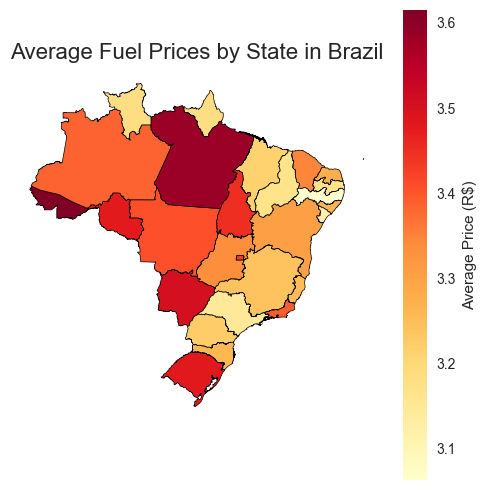

In [ ]:
brazil = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = brazil[brazil.name == 'Brazil']

states_url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
brazil_states = gpd.read_file(states_url)
avg_price_by_state = df.groupby('sigla_uf')['avg_preco_venda'].mean()
state_code_to_name = df[['sigla_uf', 'sigla_uf_nome']].drop_duplicates().set_index('sigla_uf')['sigla_uf_nome'].to_dict()
brazil_states['state_code'] = brazil_states['name'].map({v: k for k, v in state_code_to_name.items()})
brazil_states['avg_price'] = brazil_states['state_code'].map(avg_price_by_state)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

cmap = 'YlOrRd'
norm = Normalize(vmin=avg_price_by_state.min(), vmax=avg_price_by_state.max())

# Plot 
brazil_states.plot(column='avg_price', 
                    cmap=cmap,
                    ax=ax,
                    edgecolor='black',
                    linewidth=0.5,
                    legend=True,
                    legend_kwds={'label': 'Average Price (R$)'})
plt.title('Average Fuel Prices by State in Brazil', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()
    

In [ ]:
print("Performing detailed geospatial analysis of fuel pricing...")
# Prepare municipality-level data
print("\nAggregating data at municipality level...")
municipality_data = df.groupby(['id_municipio', 'id_municipio_nome']).agg({
    'avg_preco_venda': 'mean',
    'n_estabelecimentos': 'sum',
    'sigla_uf': 'first',
    'avg_preco_compra': 'mean'
}).reset_index()

# profit margin
municipality_data['profit_margin'] = municipality_data['avg_preco_venda'] - municipality_data['avg_preco_compra']
municipality_data['profit_margin_pct'] = (municipality_data['profit_margin'] / municipality_data['avg_preco_compra']) * 100


Performing detailed geospatial analysis of fuel pricing...

Aggregating data at municipality level...



Creating municipality-level choropleth map...


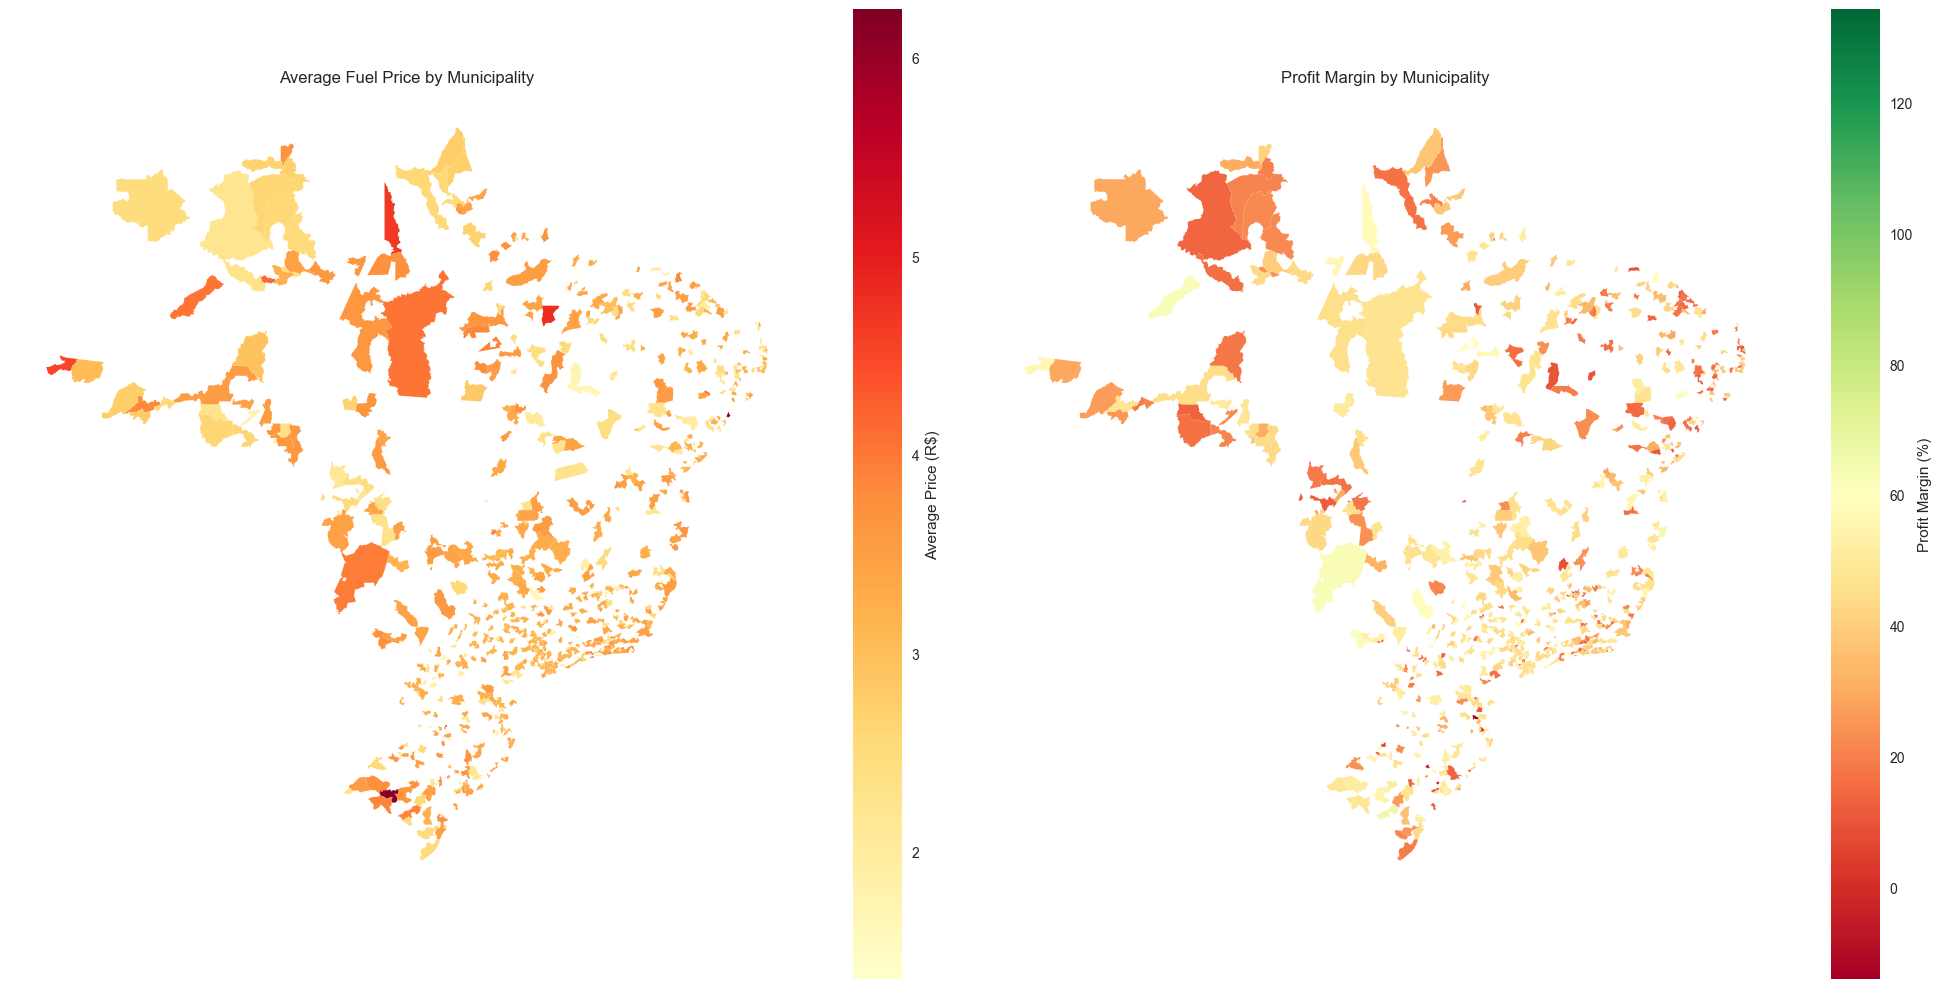

In [ ]:
brazil_municipalities = gpd.read_file('https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json')
brazil_municipalities['id_municipio'] = brazil_municipalities['id'].astype(str)
geo_data = brazil_municipalities.merge(municipality_data, on='id_municipio', how='right')

if geo_data.geometry.isna().all():
    raise ValueError("No geometry data available after merge")

print("\nCreating municipality-level choropleth map...")
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# Plot average price
geo_data.plot(column='avg_preco_venda', 
                cmap='YlOrRd', 
                legend=True,
                legend_kwds={'label': "Average Price (R$)"},
                ax=ax[0])
ax[0].set_title('Average Fuel Price by Municipality')
ax[0].axis('off')
# Plot profit margin percentage
geo_data.plot(column='profit_margin_pct', 
                cmap='RdYlGn', 
                legend=True,
                legend_kwds={'label': "Profit Margin (%)"},
                ax=ax[1])
ax[1].set_title('Profit Margin by Municipality')
ax[1].axis('off')

plt.tight_layout()
plt.show()




Analyzing price variation with distance...


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_97899/4224240205.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['centroid'] = geo_data.geometry.centroid
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_97899/4224240205.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['latitude'] = geo_data.centroid.y
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_97899/4224240205.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['longitude'] = geo_data.centroid.x


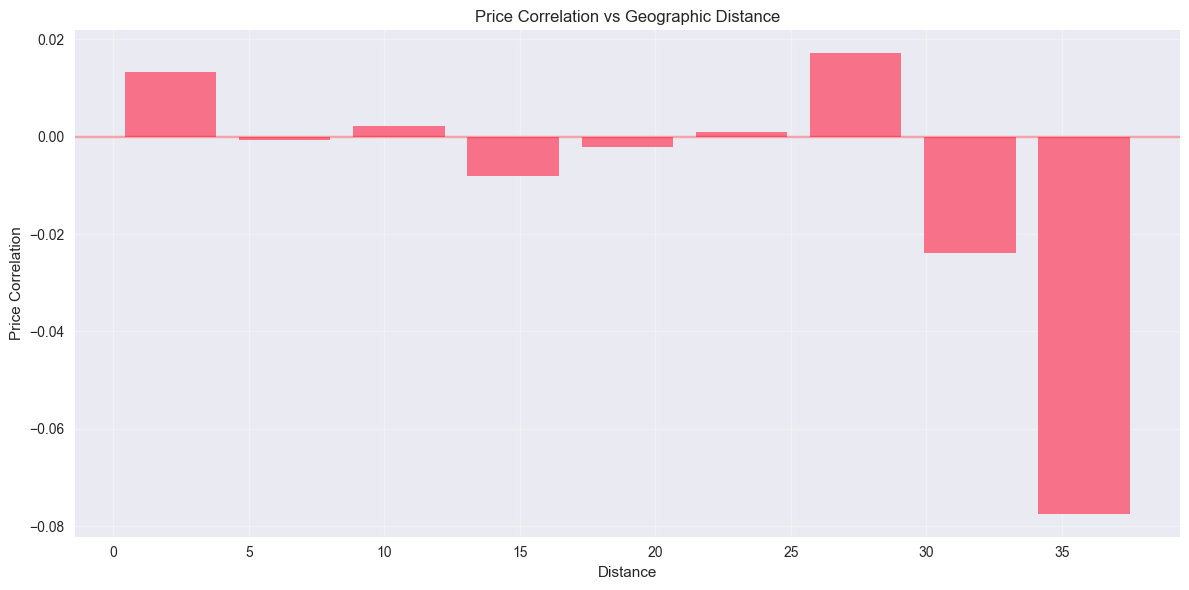


Analyzing price variation with distance...


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_97899/4224240205.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['centroid'] = geo_data.geometry.centroid
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_97899/4224240205.py:66: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['latitude'] = geo_data.centroid.y
/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_97899/4224240205.py:67: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_data['longitude'] = geo_data.centroid.x


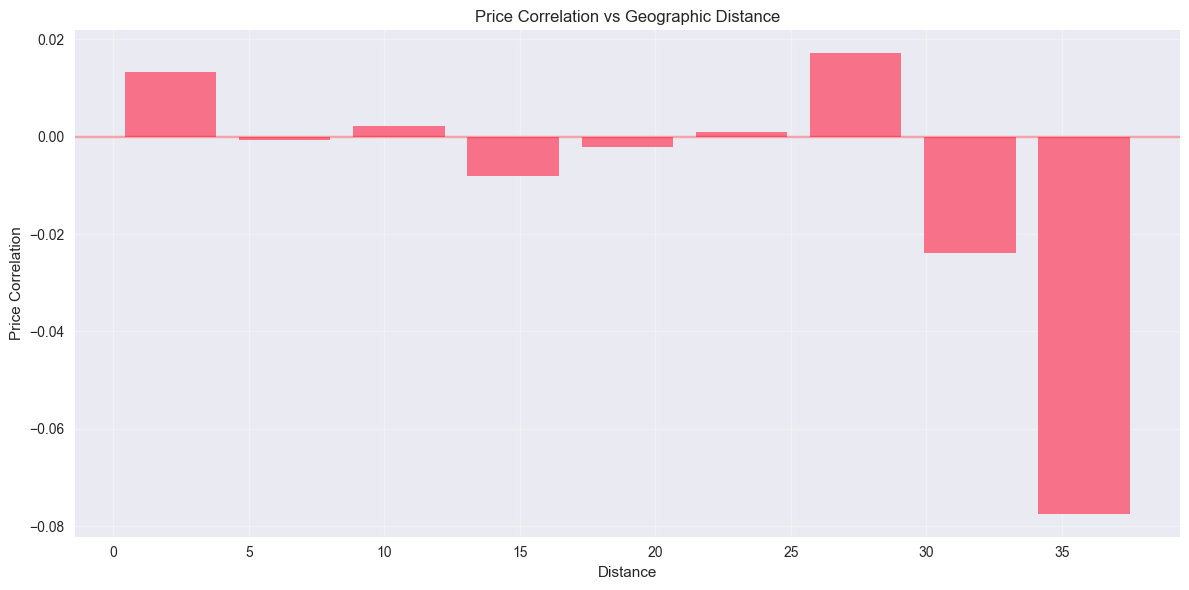

In [10]:
# Distance-based price analysis
print("\nAnalyzing price variation with distance...")

# Calculate centroids for each municipality
geo_data['centroid'] = geo_data.geometry.centroid
geo_data['latitude'] = geo_data.centroid.y
geo_data['longitude'] = geo_data.centroid.x

# Calculate distance matrix between municipalities
coords = geo_data[['latitude', 'longitude']].values
dist_matrix = distance.cdist(coords, coords, 'euclidean')

# Create distance bins
dist_bins = np.linspace(0, dist_matrix.max(), 10)

# Calculate price correlation at different distances
distance_correlations = []

for i in range(len(dist_bins)-1):
    lower = dist_bins[i]
    upper = dist_bins[i+1]
    
    pairs = []
    for j in range(len(geo_data)):
        for k in range(j+1, len(geo_data)):
            if lower <= dist_matrix[j, k] < upper:
                pairs.append((j, k))
    
    if len(pairs) > 1:
        prices1 = [geo_data.iloc[p[0]]['avg_preco_venda'] for p in pairs]
        prices2 = [geo_data.iloc[p[1]]['avg_preco_venda'] for p in pairs]
        
        # correlation
        corr, p_value = pearsonr(prices1, prices2)
        
        distance_correlations.append({
            'distance_min': lower,
            'distance_max': upper,
            'avg_distance': (lower + upper) / 2,
            'correlation': corr,
            'p_value': p_value,
            'n_pairs': len(pairs)
        })

distance_corr_df = pd.DataFrame(distance_correlations)
# Plot correlation vs distance
plt.figure(figsize=(12, 6))
plt.bar(distance_corr_df['avg_distance'], distance_corr_df['correlation'], 
        width=(dist_bins[1] - dist_bins[0]) * 0.8)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Price Correlation vs Geographic Distance')
plt.xlabel('Distance')
plt.ylabel('Price Correlation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distance-based price analysis
print("\nAnalyzing price variation with distance...")
# Calculate centroids for each municipality
geo_data['centroid'] = geo_data.geometry.centroid
geo_data['latitude'] = geo_data.centroid.y
geo_data['longitude'] = geo_data.centroid.x

# Calculate distance matrix between municipalities
coords = geo_data[['latitude', 'longitude']].values
dist_matrix = distance.cdist(coords, coords, 'euclidean')

# Create distance bins
dist_bins = np.linspace(0, dist_matrix.max(), 10)

# Calculate price correlation at different distances
distance_correlations = []

for i in range(len(dist_bins)-1):
    lower = dist_bins[i]
    upper = dist_bins[i+1]
    
    # Get municipality pairs in this distance range
    pairs = []
    for j in range(len(geo_data)):
        for k in range(j+1, len(geo_data)):
            if lower <= dist_matrix[j, k] < upper:
                pairs.append((j, k))
    
    if len(pairs) > 1:
        # Get prices for these pairs
        prices1 = [geo_data.iloc[p[0]]['avg_preco_venda'] for p in pairs]
        prices2 = [geo_data.iloc[p[1]]['avg_preco_venda'] for p in pairs]
        
        # Calculate correlation
        corr, p_value = pearsonr(prices1, prices2)
        
        distance_correlations.append({
            'distance_min': lower,
            'distance_max': upper,
            'avg_distance': (lower + upper) / 2,
            'correlation': corr,
            'p_value': p_value,
            'n_pairs': len(pairs)
        })

distance_corr_df = pd.DataFrame(distance_correlations)
# correlation vs distance
plt.figure(figsize=(12, 6))
plt.bar(distance_corr_df['avg_distance'], distance_corr_df['correlation'], 
        width=(dist_bins[1] - dist_bins[0]) * 0.8)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title('Price Correlation vs Geographic Distance')
plt.xlabel('Distance')
plt.ylabel('Price Correlation')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Main takeawaya

1. Variation in Average Prices by State and Municipality

Higher Average Prices (darker reds in the choropleths) tend to be concentrated in certain states—often those more remote or with higher logistics costs (e.g., northern or more rural areas). In municipalities with limited competition, sellers may maintain elevated prices.
Lower Prices (lighter colors) typically appear in states or regions with better infrastructure, higher competition, or closer proximity to refineries and major distribution networks.
Implication:
Prices can vary substantially by region, so a “one‐size‐fits‐all” pricing model may fail to capture local cost structures. Clients may want to set region‐specific price floors or discounts, especially in remote markets where transport cost is a critical factor.

2. Profit Margin Distribution Across Municipalities

Municipalities showing high profit margins (greenish areas in the margin map) may reflect minimal competition, premium branding, or local market conditions (e.g., lack of alternatives).
Lower or negative margins could signal more competitive environments, price wars, or potential data anomalies.
Implication:
High‐margin areas could be opportunities for expansion or targeted brand marketing, but also risk regulatory scrutiny if they appear exploitative. Conversely, low‐margin zones may benefit from operational efficiency improvements or renegotiating supply contracts.

3. Price Correlation vs. Geographic Distance

The bar chart shows how price correlations weaken—and even turn negative—over longer distances. In other words, municipalities far apart are less likely to have similar fuel prices, reflecting differing transportation costs, supply routes, local taxes, and market competition.
Short‐distance neighbors (within ~5–10 km or so) might exhibit slightly positive price correlations, suggesting that local stations often move prices in tandem.
Implication:
Clustering or grouping municipalities by distance (or by distribution routes) can help in forecasting prices and managing supply more cohesively. The negative correlation at greater distances underscores that cross‐regional pricing patterns diverge significantly.

4. Actionable Recommendations

Tailor Pricing & Supply Chain by Region

In remote, high‐price/high‐margin areas, reinforce logistics or exploit local advantage carefully. Watch out for regulatory concerns if prices exceed typical market trends.
In low‐margin, highly competitive zones, explore cost‐cutting measures, partnerships, or advanced inventory strategies to remain profitable.
Identify Expansion or Consolidation Targets

High‐margin municipalities may be prime for brand expansion if consumer demand is sufficient.
Regions with very tight margins might warrant consolidation, operational synergies, or a shift to lower‐cost brand labels.
Incorporate Distance into Forecasting Models

Price correlations drop off over distance, suggesting that data from far‐flung municipalities may not add predictive value. Consider regional or cluster‐level forecasting rather than a single national model.
Monitor and Revisit Local Taxes & Regulations

Many states or municipalities have unique taxes and regulations for fuel. Tracking these can explain part of the geographic price variation and highlight potential lobbying or compliance strategies.
By leveraging these geographic insights—especially the interplay between distance, profit margins, and average prices—you can optimize location‐specific pricing, prioritize markets for investment, and better manage the underlying supply chain logistics.